In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd '/content/drive/MyDrive/COMP 8740/Sensorless drive/'
%ls

/content/drive/MyDrive/COMP 8740/Sensorless drive
 Extra/             Final_2_Results/  'Old Final'/
 Final_1.ipynb      Final_3.ipynb      Sensorless_drive_diagnosis.txt
 Final_1_Results/   Final_3_Results/
 Final_2.ipynb      Final_Scripts/


In [13]:
import os
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

In [4]:
col_names = [f'feat{i+1}' for i in range(48)] + ['class']
df = pd.read_csv('Sensorless_drive_diagnosis.txt', header=None, names=col_names, sep=' ')
le = LabelEncoder()
df['class_enc'] = le.fit_transform(df['class'])

In [5]:
target_names = [str(c) for c in le.classes_]

In [6]:
class_counts = df['class_enc'].value_counts().sort_index()
class_counts

,count
class_enc,
0,5319
1,5319
2,5319
3,5319
4,5319
5,5319
6,5319
7,5319
8,5319


# Visualization of Dataset

In [7]:
X = df.drop(columns=['class', 'class_enc'])
y = df['class_enc']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [8]:
# filtering outliers
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)
Q1 = np.percentile(X_pca, 25, axis=0)
Q3 = np.percentile(X_pca, 75, axis=0)

IQR = Q3 - Q1
mask = np.all((X_pca >= Q1 - 1.5 * IQR) & (X_pca <= Q3 + 1.5 * IQR), axis=1)

X_filtered = X_scaled[mask]
y_filtered = y[mask]
y_filtered = y_filtered.reset_index(drop=True)

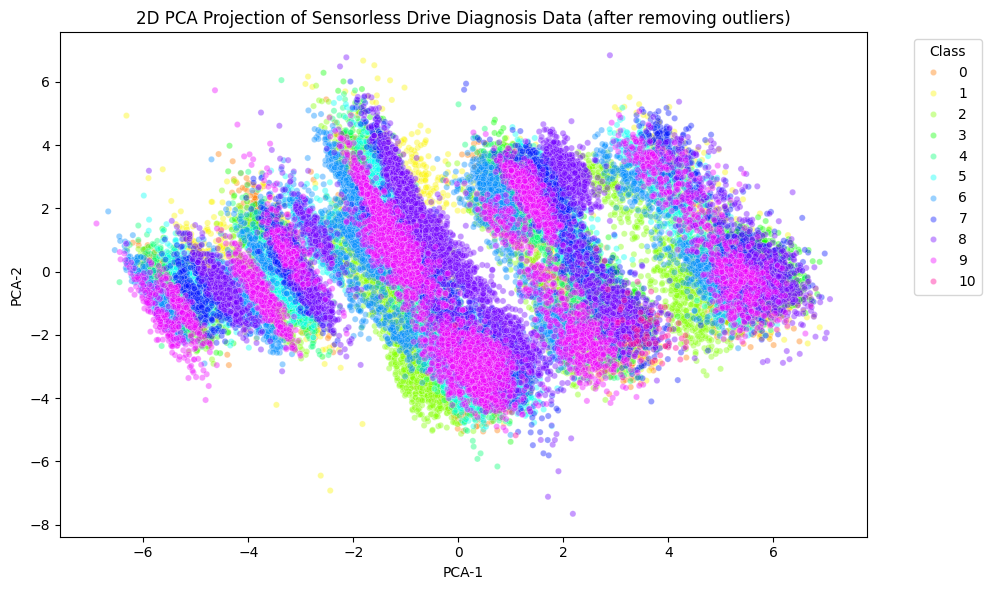

In [9]:
# reducing the dimension of 3D X_filtered to 2D for visualization with PCA
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_filtered)

df_pca_2d = pd.DataFrame(X_pca_2d, columns=['PCA-1', 'PCA-2'])
df_pca_2d['Class'] = y_filtered

plt.figure(figsize=(10, 6))
palette = sns.color_palette('hsv', n_colors=11)
sns.scatterplot(x='PCA-1', y='PCA-2', hue='Class', palette=palette, data=df_pca_2d, legend='full', s=20, alpha=0.4)
plt.title("2D PCA Projection of Sensorless Drive Diagnosis Data (after removing outliers)")
plt.xlabel("PCA-1")
plt.ylabel("PCA-2")
plt.legend(title='Class', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


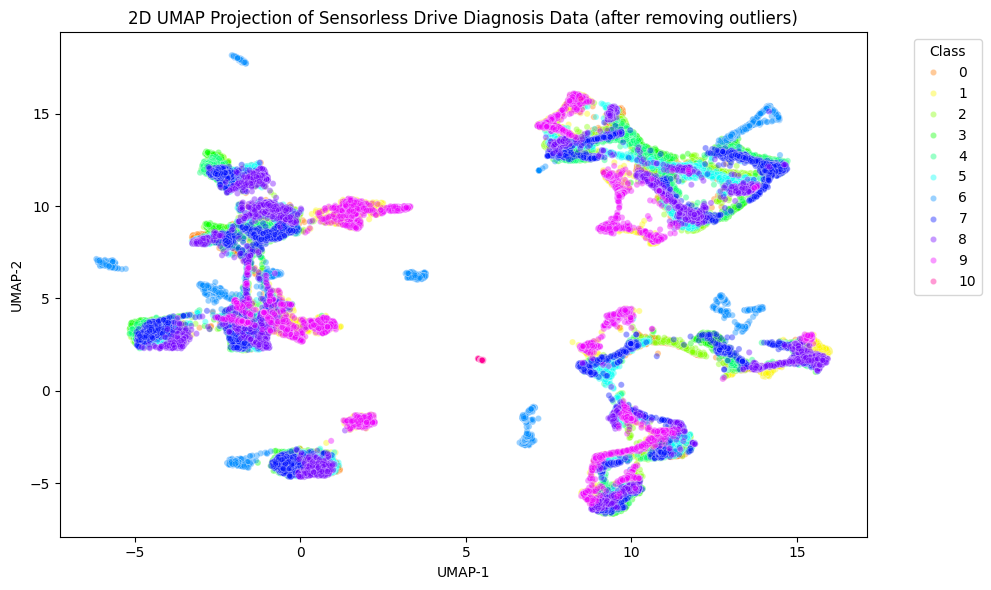

In [10]:
# reducing the dimension of 3D X_filtered to 2D for visualization with UMAP
import umap.umap_ as umap

umap_2d = umap.UMAP(n_components=2, random_state=42)
X_umap_2d = umap_2d.fit_transform(X_filtered)

df_umap_2d = pd.DataFrame(X_umap_2d, columns=['UMAP-1', 'UMAP-2'])
df_umap_2d['Class'] = y_filtered

plt.figure(figsize=(10, 6))
palette = sns.color_palette('hsv', n_colors=11)
sns.scatterplot(x='UMAP-1', y='UMAP-2', hue='Class', palette=palette, data=df_umap_2d, legend='full', s=20, alpha=0.4)
plt.title("2D UMAP Projection of Sensorless Drive Diagnosis Data (after removing outliers)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.legend(title="Class", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Coorelation Feature Map

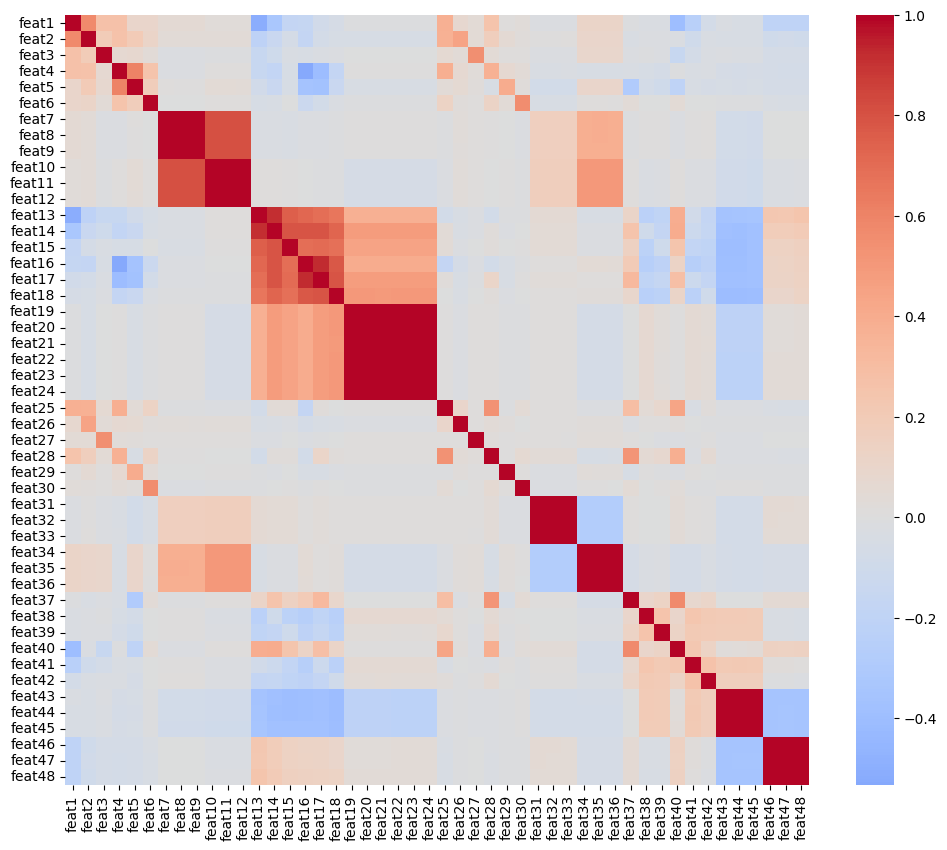

In [11]:
corr = df.drop(['class','class_enc'], axis=1).corr()
import seaborn as sns
plt.figure(figsize=(12,10))
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.show()

In [29]:
X = df.drop(columns=['class', 'class_enc'])
y = df['class_enc']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [30]:
param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'solver': ['lbfgs', 'saga']
}
scoring = {
    'accuracy': 'accuracy',
    'f1_macro': 'f1_macro'
}
model = LogisticRegression(max_iter=10000, random_state=42)
grid_search = GridSearchCV(model, param_grid_lr, cv=3, scoring=scoring, refit='accuracy', return_train_score=True, verbose=2, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)
print("Best parameters:", grid_search.best_params_)

results_lr_df = pd.DataFrame(grid_search.cv_results_)
y_pred = grid_search.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
test_recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
test_f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

test_metrics_lr_df = pd.DataFrame([{
    'Test Accuracy': test_accuracy,
    'Test Precision': test_precision,
    'Test Recall': test_recall,
    'Test F1 Score': test_f1
}])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters: {'C': 10, 'solver': 'lbfgs'}
Test Accuracy: 0.9247
Test Precision: 0.9249
Test Recall: 0.9247
Test F1 Score: 0.9247


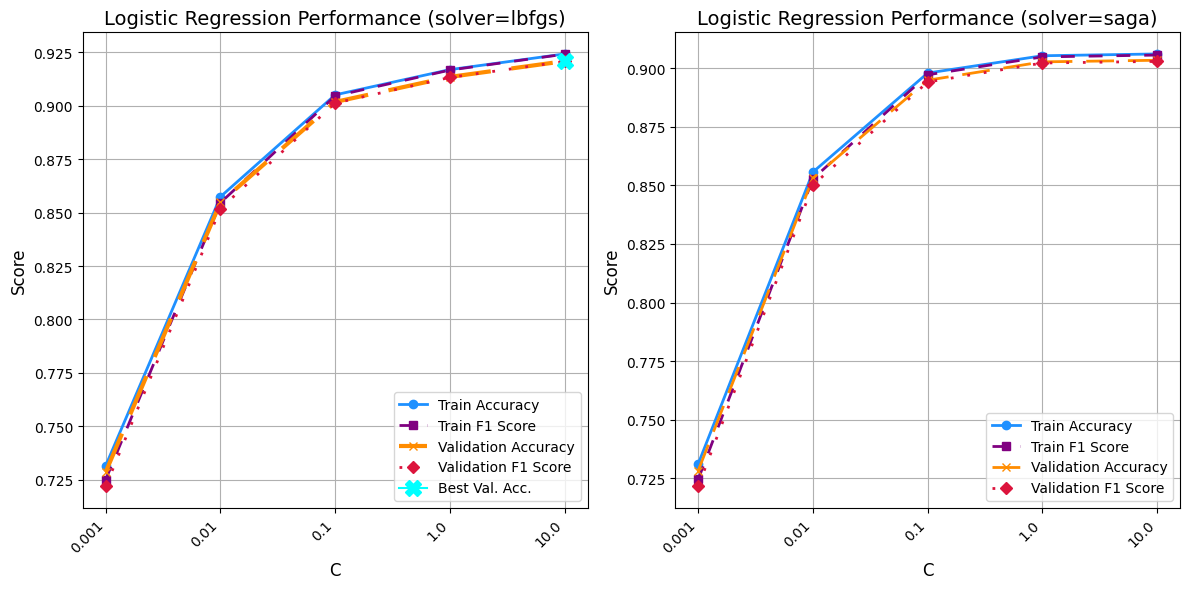

In [35]:
results_lr_df['param_combination'] = results_lr_df['param_C'].astype(str) + " | " + results_lr_df['param_solver']
results_lbfgs = results_lr_df[results_lr_df['param_solver'] == 'lbfgs'].copy()
results_saga = results_lr_df[results_lr_df['param_solver'] == 'saga'].copy()
results_lbfgs['param_combination'] = results_lbfgs['param_combination'].apply(lambda x: x.split(' | ')[0])
results_saga['param_combination'] = results_saga['param_combination'].apply(lambda x: x.split(' | ')[0])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.plot(results_lbfgs['param_combination'], results_lbfgs['mean_train_accuracy'], linestyle='-', marker='o', label='Train Accuracy', color='dodgerblue', linewidth=2)
ax1.plot(results_lbfgs['param_combination'], results_lbfgs['mean_train_f1_macro'], linestyle='-.', dashes=(5, 5), marker='s', label='Train F1 Score', color='purple', linewidth=2)
ax1.plot(results_lbfgs['param_combination'], results_lbfgs['mean_test_accuracy'], linestyle='--', dashes=(10, 5), marker='x', label='Validation Accuracy', color='darkorange', linewidth=3)
ax1.plot(results_lbfgs['param_combination'], results_lbfgs['mean_test_f1_macro'], linestyle=':', dashes=(1, 5), marker='D', label='Validation F1 Score', color='crimson', linewidth=2)
ax1.set_title('Logistic Regression Performance (solver=lbfgs)', fontsize=14)
ax1.set_xlabel('C', fontsize=12)
ax1.set_ylabel('Score', fontsize=12)
ax1.tick_params(axis='x', rotation=45)
for x_tick in ax1.get_xticklabels():
    x_tick.set_ha('right')
ax1.legend()
ax1.grid(True)

ax2.plot(results_saga['param_combination'], results_saga['mean_train_accuracy'], linestyle='-', marker='o', label='Train Accuracy', color='dodgerblue', linewidth=2)
ax2.plot(results_saga['param_combination'], results_saga['mean_train_f1_macro'], linestyle='-.', dashes=(5, 5), marker='s', label='Train F1 Score', color='purple', linewidth=2)
ax2.plot(results_saga['param_combination'], results_saga['mean_test_accuracy'], linestyle='--', dashes=(10, 5), marker='x', label='Validation Accuracy', color='darkorange', linewidth=2)
ax2.plot(results_saga['param_combination'], results_saga['mean_test_f1_macro'], linestyle=':', dashes=(1, 5), marker='D', label='Validation F1 Score', color='crimson', linewidth=2)
ax2.set_title('Logistic Regression Performance (solver=saga)', fontsize=14)
ax2.set_xlabel('C', fontsize=12)
ax2.set_ylabel('Score', fontsize=12)
ax2.tick_params(axis='x', rotation=45)
for x_tick in ax2.get_xticklabels():
    x_tick.set_ha('right')
ax2.legend()
ax2.grid(True)

best_row = results_lr_df.loc[results_lr_df['mean_test_accuracy'].idxmax()]
best_C = str(best_row['param_C'])
best_solver = best_row['param_solver']
best_accuracy = best_row['mean_test_accuracy']
if best_solver == 'lbfgs':
    ax1.plot(best_C, best_accuracy, marker='X', color='cyan', markersize=12, label='Best Val. Acc.')
else:
    ax2.plot(best_C, best_accuracy, marker='X', color='cyan', markersize=12, label='Best Val. Acc.')
ax1.legend()
ax2.legend()
plt.tight_layout()
plt.show()

In [48]:
results_lr_df.to_csv('Final_Scripts/Final1/GS_LR.csv', index=0)
test_metrics_lr_df.to_csv('Final_Scripts/Final1/Test_LR.csv', index=0)

In [36]:
param_grid_sgd = {
    'loss': ['hinge', 'log_loss'],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'alpha': [1e-4, 1e-3],
    'learning_rate': ['optimal', 'invscaling'],
}

scoring = {
    'accuracy': 'accuracy',
    'f1_macro': 'f1_macro'
}

model = SGDClassifier(max_iter=1000, eta0=0.01, random_state=42)
grid_search = GridSearchCV(model, param_grid_sgd, cv=3, scoring=scoring, refit='accuracy', return_train_score=True, verbose=2, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)
print("Best parameters:", grid_search.best_params_)
results_sgd_df = pd.DataFrame(grid_search.cv_results_)
y_pred = grid_search.predict(X_test_scaled)

test_accuracy = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
test_recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
test_f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

test_metrics_sgd_df = pd.DataFrame([{
    'Test Accuracy': test_accuracy,
    'Test Precision': test_precision,
    'Test Recall': test_recall,
    'Test F1 Score': test_f1
}])

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best parameters: {'alpha': 0.001, 'learning_rate': 'optimal', 'loss': 'log_loss', 'penalty': 'elasticnet'}
Test Accuracy: 0.7462
Test Precision: 0.7462
Test Recall: 0.7462
Test F1 Score: 0.7450


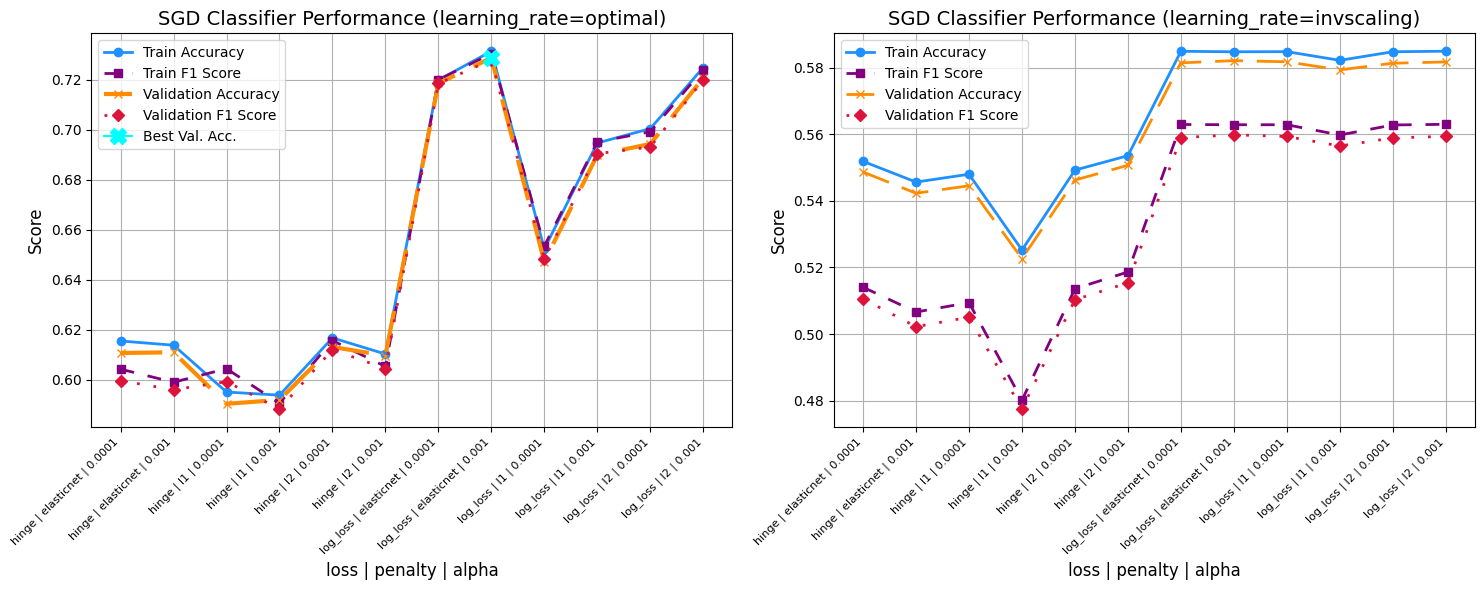

In [52]:
results_sgd_df['param_combination'] = (results_sgd_df['param_loss'].astype(str) + " | " + results_sgd_df['param_penalty'].astype(str) + " | " +
                                       results_sgd_df['param_alpha'].astype(str) + " | " + results_sgd_df['param_learning_rate'].astype(str))
results_lr_opt = results_sgd_df[results_sgd_df['param_learning_rate'] == 'optimal'].copy()
results_lr_inv = results_sgd_df[results_sgd_df['param_learning_rate'] == 'invscaling'].copy()
results_lr_opt.loc[:, 'param_combination'] = results_lr_opt['param_combination'].apply(lambda x: ' | '.join(x.split(' | ')[:3]))
results_lr_inv.loc[:, 'param_combination'] = results_lr_inv['param_combination'].apply(lambda x: ' | '.join(x.split(' | ')[:3]))
sort_cols = ['param_loss', 'param_penalty', 'param_alpha']

results_lr_opt = results_lr_opt.sort_values(by=sort_cols).reset_index(drop=True)
results_lr_inv = results_lr_inv.sort_values(by=sort_cols).reset_index(drop=True)
results_lr_opt['param_combination'] = (results_lr_opt['param_loss'] + " | " + results_lr_opt['param_penalty'] + " | " + results_lr_opt['param_alpha'].astype(str))
results_lr_inv['param_combination'] = (results_lr_inv['param_loss'] + " | " + results_lr_inv['param_penalty'] + " | " + results_lr_inv['param_alpha'].astype(str))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
ax1.plot(results_lr_opt['param_combination'], results_lr_opt['mean_train_accuracy'], linestyle='-', marker='o', label='Train Accuracy', color='dodgerblue', linewidth=2)
ax1.plot(results_lr_opt['param_combination'], results_lr_opt['mean_train_f1_macro'], linestyle='-.', dashes=(5,5), marker='s', label='Train F1 Score', color='purple', linewidth=2)
ax1.plot(results_lr_opt['param_combination'], results_lr_opt['mean_test_accuracy'], linestyle='--', dashes=(10,5), marker='x', label='Validation Accuracy', color='darkorange', linewidth=3)
ax1.plot(results_lr_opt['param_combination'], results_lr_opt['mean_test_f1_macro'], linestyle=':', dashes=(1,5), marker='D', label='Validation F1 Score', color='crimson', linewidth=2)

ax1.set_title('SGD Classifier Performance (learning_rate=optimal)', fontsize=14)
ax1.set_xlabel('loss | penalty | alpha', fontsize=12)
ax1.set_ylabel('Score', fontsize=12)
ax1.tick_params(axis='x', rotation=45)
for tick in ax1.get_xticklabels():
    tick.set_ha('right')
    tick.set_fontsize(8)
ax1.legend()
ax1.grid(True)

ax2.plot(results_lr_inv['param_combination'], results_lr_inv['mean_train_accuracy'], linestyle='-', marker='o', label='Train Accuracy', color='dodgerblue', linewidth=2)
ax2.plot(results_lr_inv['param_combination'], results_lr_inv['mean_train_f1_macro'], linestyle='-.', dashes=(5,5), marker='s', label='Train F1 Score', color='purple', linewidth=2)
ax2.plot(results_lr_inv['param_combination'], results_lr_inv['mean_test_accuracy'], linestyle='--', dashes=(10,5), marker='x', label='Validation Accuracy', color='darkorange', linewidth=2)
ax2.plot(results_lr_inv['param_combination'], results_lr_inv['mean_test_f1_macro'], linestyle=':', dashes=(1,5), marker='D', label='Validation F1 Score', color='crimson', linewidth=2)

ax2.set_title('SGD Classifier Performance (learning_rate=invscaling)', fontsize=14)
ax2.set_xlabel('loss | penalty | alpha', fontsize=12)
ax2.set_ylabel('Score', fontsize=12)
ax2.tick_params(axis='x', rotation=45)
for tick in ax2.get_xticklabels():
    tick.set_ha('right')
    tick.set_fontsize(8)
ax2.legend()
ax2.grid(True)

best_row = results_sgd_df.loc[results_sgd_df['mean_test_accuracy'].idxmax()]
best_label = best_row['param_loss'] + " | " + best_row['param_penalty'] + " | " + str(best_row['param_alpha'])
best_lr = best_row['param_learning_rate']
best_acc = best_row['mean_test_accuracy']

if best_lr == 'optimal':
    ax1.plot(best_label, best_acc, marker='X', color='cyan', markersize=12, label='Best Val. Acc.')
    ax1.legend()
else:
    ax2.plot(best_label, best_acc, marker='X', color='cyan', markersize=12, label='Best Val. Acc.')
    ax2.legend()

plt.tight_layout()
plt.show()

In [47]:
results_sgd_df.to_csv('Final_Scripts/Final1/GS_SGD.csv', index=0)
test_metrics_sgd_df.to_csv('Final_Scripts/Final1/Test_SGD.csv', index=0)

In [49]:
param_grid_nb = {
    'var_smoothing': [1e-12, 1e-9, 1e-6, 1e-3, 0.01, 0.1, 1.0]
}

scoring = {
    'accuracy': 'accuracy',
    'f1_macro': 'f1_macro',
}

model = GaussianNB()
grid_search = GridSearchCV(model, param_grid_nb, cv=3, scoring=scoring, refit='accuracy', return_train_score=True, verbose=2, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)
print("Best parameters:", grid_search.best_params_)
results_nb_df = pd.DataFrame(grid_search.cv_results_)

y_pred = grid_search.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
test_recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
test_f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

test_metrics_nb_df = pd.DataFrame([{
    'Test Accuracy': test_accuracy,
    'Test Precision': test_precision,
    'Test Recall': test_recall,
    'Test F1 Score': test_f1
}])

Fitting 3 folds for each of 7 candidates, totalling 21 fits
Best parameters: {'var_smoothing': 0.001}
Test Accuracy: 0.7303
Test Precision: 0.7755
Test Recall: 0.7303
Test F1 Score: 0.6743


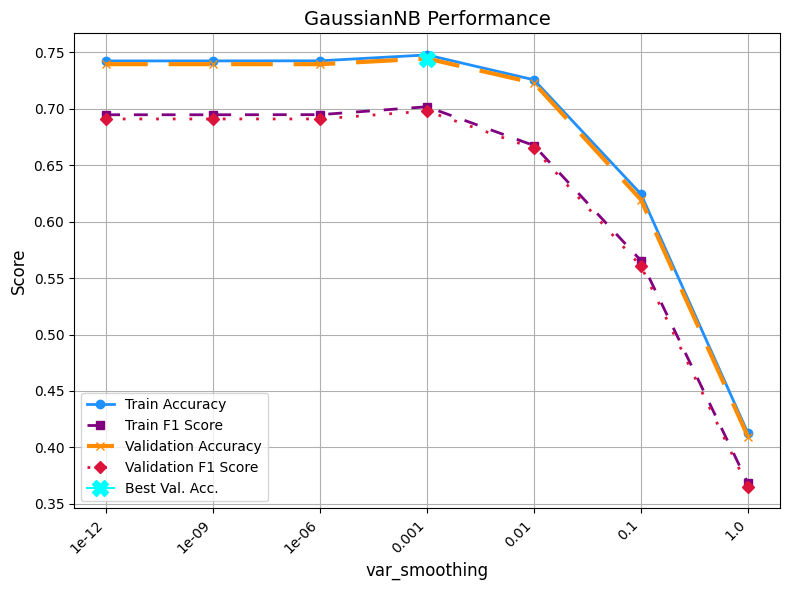

In [69]:
results_nb_df['param_combination'] = results_nb_df['param_var_smoothing'].astype(str)
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(results_nb_df['param_combination'], results_nb_df['mean_train_accuracy'], linestyle='-', marker='o', label='Train Accuracy', color='dodgerblue', linewidth=2)
ax.plot(results_nb_df['param_combination'], results_nb_df['mean_train_f1_macro'], linestyle='-.', dashes=(5,5), marker='s', label='Train F1 Score', color='purple', linewidth=2)
ax.plot(results_nb_df['param_combination'], results_nb_df['mean_test_accuracy'], linestyle='--', dashes=(10,5), marker='x', label='Validation Accuracy', color='darkorange', linewidth=3)
ax.plot(results_nb_df['param_combination'], results_nb_df['mean_test_f1_macro'], linestyle=':', dashes=(1,5), marker='D', label='Validation F1 Score', color='crimson', linewidth=2)

ax.set_title('GaussianNB Performance', fontsize=14)
ax.set_xlabel('var_smoothing', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.tick_params(axis='x', rotation=45)
for tick in ax.get_xticklabels():
    tick.set_ha('right')
best_row = results_nb_df.loc[results_nb_df['mean_test_accuracy'].idxmax()]
best_var_smooth = str(best_row['param_var_smoothing'])
best_acc = best_row['mean_test_accuracy']
ax.plot(best_var_smooth, best_acc, marker='X', color='cyan', markersize=12, label='Best Val. Acc.')

ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

In [53]:
results_nb_df.to_csv('Final_Scripts/Final1/GS_NB.csv', index=0)
test_metrics_nb_df.to_csv('Final_Scripts/Final1/Test_NB.csv', index=0)

In [62]:
param_grid_lda = {
    'shrinkage': [None, 'auto'],
    'solver': ['svd', 'lsqr', 'eigen']
}
scoring = {
    'accuracy': 'accuracy',
    'f1_macro': 'f1_macro',
}

model = LinearDiscriminantAnalysis()
grid_search = GridSearchCV(model, param_grid_lda, cv=3, scoring=scoring, refit='accuracy', return_train_score=True, verbose=2, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)
print("Best parameters:", grid_search.best_params_)

y_pred = grid_search.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
test_recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
test_f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

results_lda_df = pd.DataFrame(grid_search.cv_results_)
test_metrics_lda_df = pd.DataFrame([{
    'Test Accuracy': test_accuracy,
    'Test Precision': test_precision,
    'Test Recall': test_recall,
    'Test F1 Score': test_f1
}])

Fitting 3 folds for each of 6 candidates, totalling 18 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
3 fits failed out of a total of 18.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py", line 700, in fit
    raise NotImplementedError(

Best parameters: {'shrinkage': None, 'solver': 'svd'}
Test Accuracy: 0.8496
Test Precision: 0.8493
Test Recall: 0.8496
Test F1 Score: 0.8491


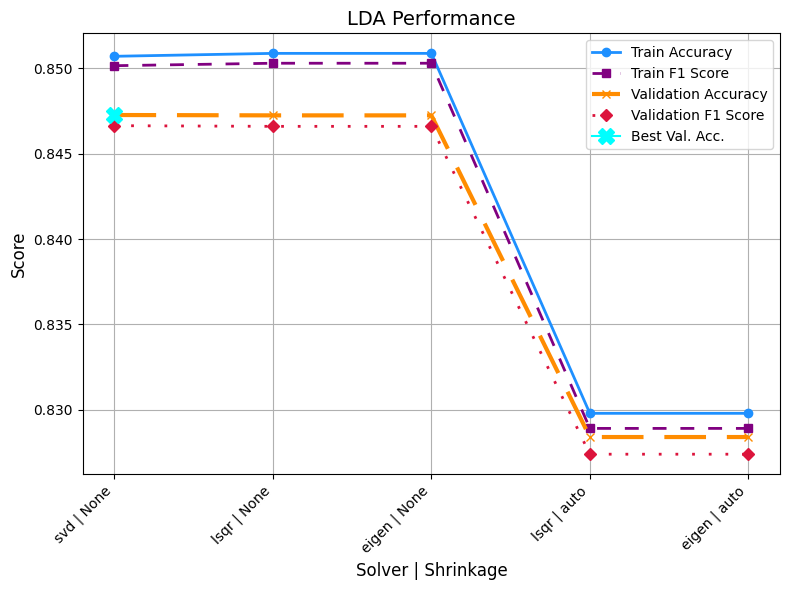

In [63]:
results_lda_df = results_lda_df.drop(3).reset_index(drop=True)
results_lda_df['param_combination'] = results_lda_df['param_solver'].astype(str) + " | " + results_lda_df['param_shrinkage'].astype(str)

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(results_lda_df['param_combination'], results_lda_df['mean_train_accuracy'], linestyle='-', marker='o', label='Train Accuracy', color='dodgerblue', linewidth=2)

ax.plot(results_lda_df['param_combination'], results_lda_df['mean_train_f1_macro'], linestyle='-.', dashes=(5,5), marker='s', label='Train F1 Score', color='purple', linewidth=2)

ax.plot(results_lda_df['param_combination'], results_lda_df['mean_test_accuracy'], linestyle='--', dashes=(10,5), marker='x', label='Validation Accuracy', color='darkorange', linewidth=3)

ax.plot(results_lda_df['param_combination'], results_lda_df['mean_test_f1_macro'], linestyle=':', dashes=(1,5), marker='D', label='Validation F1 Score', color='crimson', linewidth=2)

best_row = results_lda_df.loc[results_lda_df['mean_test_accuracy'].idxmax()]
best_combo = f"{best_row['param_solver']} | {best_row['param_shrinkage']}"
best_val_acc = best_row['mean_test_accuracy']
ax.plot(best_combo, best_val_acc, marker='X', color='cyan', markersize=12, label='Best Val. Acc.')

ax.set_title('LDA Performance', fontsize=14)
ax.set_xlabel('Solver | Shrinkage', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.tick_params(axis='x', rotation=45)
for tick in ax.get_xticklabels():
    tick.set_ha('right')

ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

In [66]:
results_lda_df.to_csv('Final_Scripts/Final1/GS_LDA.csv', index=0)
test_metrics_lda_df.to_csv('Final_Scripts/Final1/Test_LDA.csv', index=0)

In [64]:
param_grid_qda = {
    'reg_param': [0.0, 0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]
}
scoring = {
    'accuracy': 'accuracy',
    'f1_macro': 'f1_macro',
}
model = QuadraticDiscriminantAnalysis()
grid_search = GridSearchCV(model, param_grid=param_grid_qda, scoring=scoring, refit='accuracy', return_train_score=True, cv=3, verbose=2, n_jobs=-1 )
grid_search.fit(X_train_scaled, y_train)
print("Best parameters:", grid_search.best_params_)
results_qda_df = pd.DataFrame(grid_search.cv_results_)

y_pred = grid_search.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
test_recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
test_f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

test_metrics_qda_df = pd.DataFrame([{
    'Test Accuracy': test_accuracy,
    'Test Precision': test_precision,
    'Test Recall': test_recall,
    'Test F1 Score': test_f1
}])

Fitting 3 folds for each of 8 candidates, totalling 24 fits


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 2 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 3 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Best parameters: {'reg_param': 0.0}
Test Accuracy: 0.8349
Test Precision: 0.8671
Test Recall: 0.8349
Test F1 Score: 0.8115


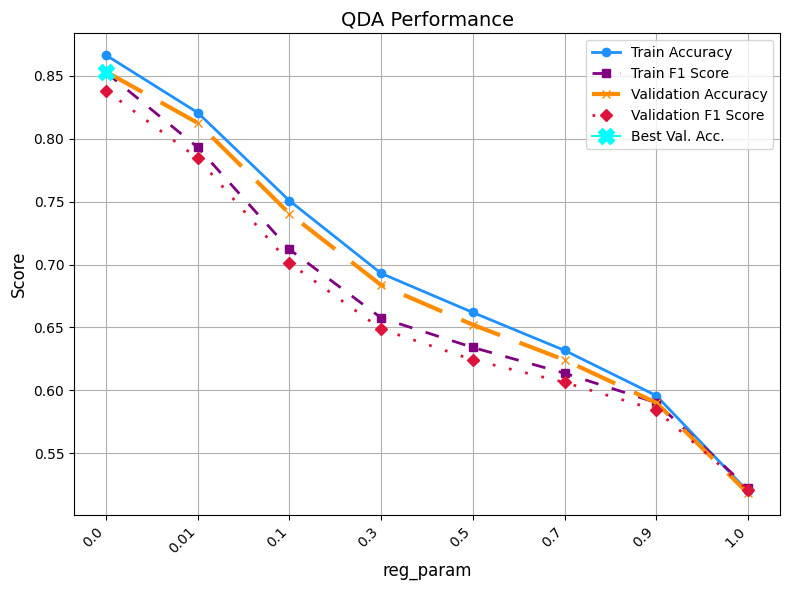

In [70]:
results_qda_df['param_combination'] = results_qda_df['param_reg_param'].astype(str)
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(results_qda_df['param_combination'], results_qda_df['mean_train_accuracy'], linestyle='-', marker='o', label='Train Accuracy', color='dodgerblue', linewidth=2)
ax.plot(results_qda_df['param_combination'], results_qda_df['mean_train_f1_macro'], linestyle='-.', dashes=(5, 5), marker='s', label='Train F1 Score', color='purple', linewidth=2)
ax.plot(results_qda_df['param_combination'], results_qda_df['mean_test_accuracy'], linestyle='--', dashes=(10, 5), marker='x', label='Validation Accuracy', color='darkorange', linewidth=3)
ax.plot(results_qda_df['param_combination'], results_qda_df['mean_test_f1_macro'], linestyle=':', dashes=(1, 5), marker='D', label='Validation F1 Score', color='crimson', linewidth=2)

best_row = results_qda_df.loc[results_qda_df['mean_test_accuracy'].idxmax()]
best_param = str(best_row['param_reg_param'])
best_val_acc = best_row['mean_test_accuracy']
ax.plot(best_param, best_val_acc, marker='X', color='cyan', markersize=12, label='Best Val. Acc.')
ax.set_title('QDA Performance', fontsize=14)
ax.set_xlabel('reg_param', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.tick_params(axis='x', rotation=45)
for tick in ax.get_xticklabels():
    tick.set_ha('right')

ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

In [67]:
results_qda_df.to_csv('Final_Scripts/Final1/GS_QDA.csv', index=0)
test_metrics_qda_df.to_csv('Final_Scripts/Final1/Test_QDA.csv', index=0)